<a href="https://colab.research.google.com/github/mehang/Improvised-CNN/blob/master/notebook/Cats-Vs-Dogs/Resized%20cats%20vs%20dogs/3*3/dogs_v_cats_3_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


In [3]:
!unzip /content/drive/My\ Drive/Gabor\ Dataset/all-cats-vs-dogs.zip -d cats-vs-dogs

Streaming output truncated to the last 5000 lines.
  inflating: cats-vs-dogs/all/cat.4909.jpg  
  inflating: cats-vs-dogs/all/cat.8674.jpg  
  inflating: cats-vs-dogs/all/cat.4471.jpg  
  inflating: cats-vs-dogs/all/cat.4193.jpg  
  inflating: cats-vs-dogs/all/cat.8593.jpg  
  inflating: cats-vs-dogs/all/cat.8512.jpg  
  inflating: cats-vs-dogs/all/cat.6828.jpg  
  inflating: cats-vs-dogs/all/cat.1070.jpg  
  inflating: cats-vs-dogs/all/cat.4311.jpg  
  inflating: cats-vs-dogs/all/cat.983.jpg  
  inflating: cats-vs-dogs/all/cat.448.jpg  
  inflating: cats-vs-dogs/all/cat.2922.jpg  
  inflating: cats-vs-dogs/all/cat.10328.jpg  
  inflating: cats-vs-dogs/all/cat.3356.jpg  
  inflating: cats-vs-dogs/all/cat.11657.jpg  
  inflating: cats-vs-dogs/all/cat.3913.jpg  
  inflating: cats-vs-dogs/all/cat.4196.jpg  
  inflating: cats-vs-dogs/all/cat.11509.jpg  
  inflating: cats-vs-dogs/all/cat.4105.jpg  
  inflating: cats-vs-dogs/all/cat.6044.jpg  
  inflating: cats-vs-dogs/all/cat.6846.jpg  
  i

In [4]:
FAST_RUN = False
IMAGE_WIDTH=256
IMAGE_HEIGHT=256
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
INITIAL_FILTER=(3,3)

In [7]:
filenames = os.listdir("cats-vs-dogs/all/")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [8]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [9]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [10]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=32

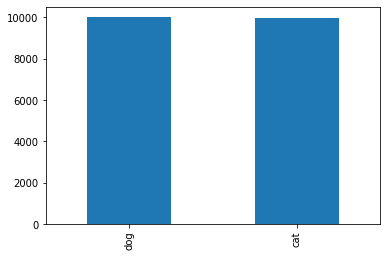

In [11]:
train_df['category'].value_counts().plot.bar()

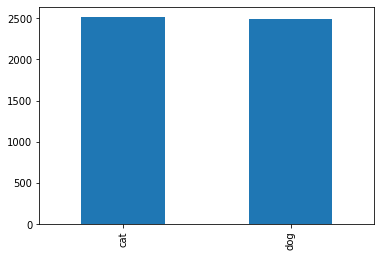

In [12]:
validate_df['category'].value_counts().plot.bar()

In [13]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
)
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "cats-vs-dogs/all/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [14]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "cats-vs-dogs/all/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [15]:
# Importing the Keras libraries and packages
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

num_classes = 2

classifier = Sequential([
    # layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_size, img_size, 3)),
    layers.Conv2D(32, kernel_size=INITIAL_FILTER, strides=(1,1), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    layers.Conv2D(64, kernel_size=(3,3), strides=(2,2), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(128, kernel_size=(3,3), strides=(2,2), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    layers.Conv2D(128, kernel_size=(3,3), strides=(2,2), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 63, 63, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 128)         0

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import time

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,  
                              min_delta=1e-4, mode='min', verbose=1)

stop_alg = EarlyStopping(monitor='val_loss', patience=35, 
                         restore_best_weights=True, verbose=1)

callbacks = [stop_alg, reduce_lr]

epochs=20 if FAST_RUN else 1000

start = time.perf_counter()
classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
hist = classifier.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)
finish = time.perf_counter()

Epoch 1/1000
625/625 [==============================] - 64s 103ms/step - loss: 0.7045 - accuracy: 0.5017 - val_loss: 0.6930 - val_accuracy: 0.4998
Epoch 2/1000
625/625 [==============================] - 62s 99ms/step - loss: 0.6944 - accuracy: 0.5013 - val_loss: 0.6949 - val_accuracy: 0.5030
Epoch 3/1000
625/625 [==============================] - 61s 98ms/step - loss: 0.6861 - accuracy: 0.5383 - val_loss: 0.6706 - val_accuracy: 0.5865
Epoch 4/1000
625/625 [==============================] - 61s 97ms/step - loss: 0.6678 - accuracy: 0.5863 - val_loss: 0.6537 - val_accuracy: 0.6206
Epoch 5/1000
625/625 [==============================] - 60s 97ms/step - loss: 0.6518 - accuracy: 0.6209 - val_loss: 0.6349 - val_accuracy: 0.6392
Epoch 6/1000
625/625 [==============================] - 60s 97ms/step - loss: 0.6352 - accuracy: 0.6413 - val_loss: 0.6130 - val_accuracy: 0.6679
Epoch 7/1000
625/625 [==============================] - 61s 97ms/step - loss: 0.6148 - accuracy: 0.6640 - val_loss: 0.6267 

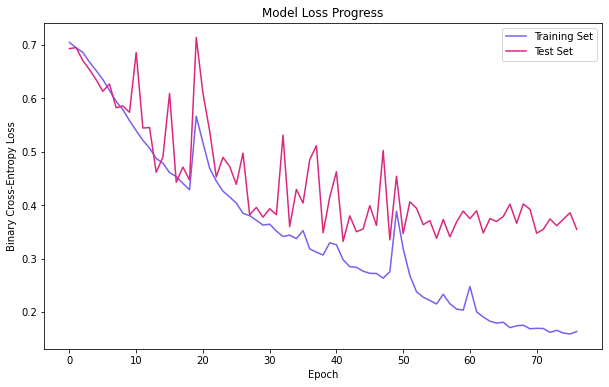

In [17]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,6))
plt.plot(hist.history['loss'], color='#785ef0')
plt.plot(hist.history['val_loss'], color='#dc267f')
plt.title('Model Loss Progress')
plt.ylabel('Binary Cross-Entropy Loss')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Test Set'], loc='upper right')
plt.savefig('cnn.dogsvscats.loss-2.png', dpi=350, bbox_inches='tight')
plt.show()

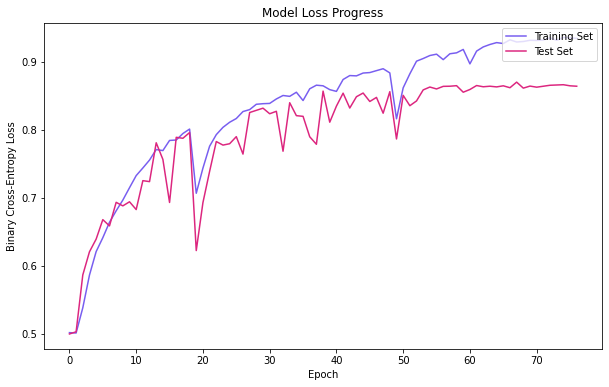

In [18]:
fig = plt.figure(figsize=(10,6))
plt.plot(hist.history['accuracy'], color='#785ef0')
plt.plot(hist.history['val_accuracy'], color='#dc267f')
plt.title('Model Loss Progress')
plt.ylabel('Binary Cross-Entropy Loss')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Test Set'], loc='upper right')
plt.savefig('cnn-dogs-vs-cats-accuracy-2.png', dpi=350, bbox_inches='tight')
plt.show()

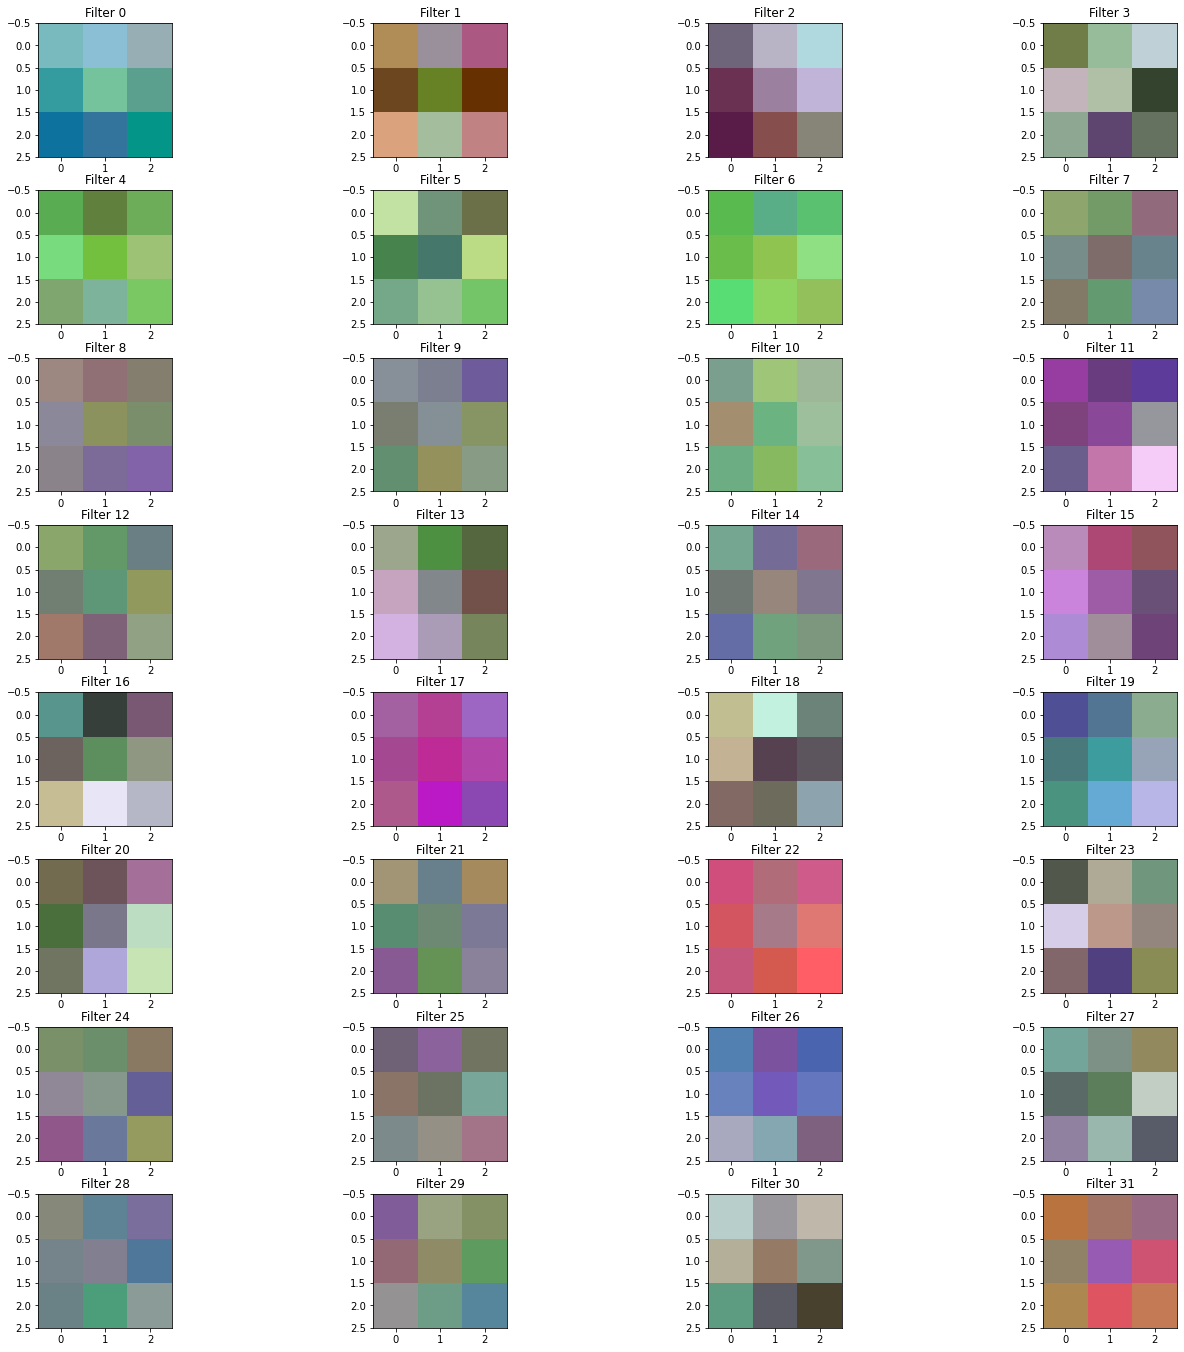

In [19]:
from sklearn.preprocessing import MinMaxScaler

cnnl1 = classifier.layers[0].name   # get the name of the first conv layer
W = classifier.get_layer(name=cnnl1).get_weights()[0]   #get the filters
wshape = W.shape  #save the original shape

# this part will scale to [0, 1] for visualization purposes
scaler = MinMaxScaler()
scaler.fit(W.reshape(-1,1))
W = scaler.transform(W.reshape(-1,1))
W = W.reshape(wshape)

# since there are 32 filters, we will display them 8x8
fig, axs = plt.subplots(8,4, figsize=(24,24))
fig.subplots_adjust(hspace = .25, wspace=.001)
axs = axs.ravel()
for i in range(W.shape[-1]):
  # we reshape to a 3D (RGB) image shape and display
  h = np.reshape(W[:,:,:,i], (INITIAL_FILTER[0],INITIAL_FILTER[1],3))
  axs[i].imshow(h)
  axs[i].set_title('Filter ' + str(i))    
plt.savefig("cnn-dogs-vs-cats.full.filters-2.png", bbox_inches='tight', dpi=350)

-0.5298998 0.43622977


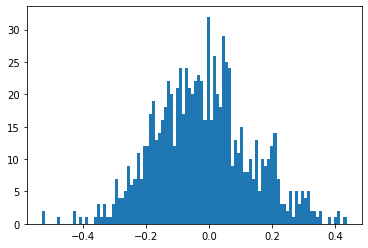

In [20]:
cnnl1 = classifier.layers[0].name   # get the name of the first conv layer
W = classifier.get_layer(name=cnnl1).get_weights()[0]
plt.hist(W.ravel(), bins=100)
print(np.min(W),np.max(W))